# Time Series

In [113]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.tsa.arima.model import ARIMA
import math

import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_pacf
register_matplotlib_converters()

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# navigate folders
p=Path(os.getcwd())
os.chdir(p.parent)
#os.getcwd()

'/Users/Chris/Documents/00.Data_science/00.MADS/GitHub_MADS/portfolio'

In [3]:
# load data
covid = pd.read_csv('assets/time_series_covid19_confirmed_global.csv')
daily_new_cases = covid.iloc[:,4:].sum(axis=0).diff()[1:]
daily_new_cases.index = pd.to_datetime(daily_new_cases.index)
daily_new_cases = daily_new_cases.astype('float')

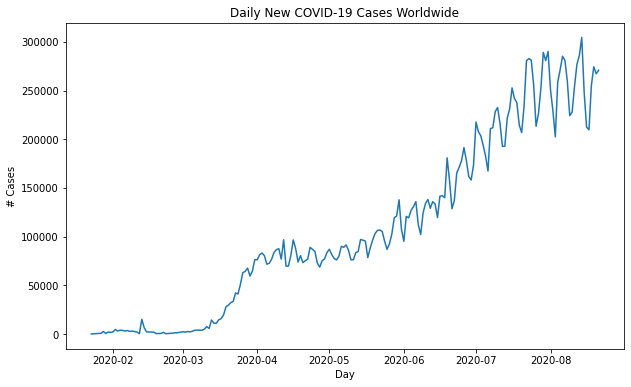

In [5]:
# Let's plot and see the time series

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_new_cases)
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")

del fig, ax

## Seasonal Decomposition
With the time series ready, let's first perform a seasonal decomposition using tools from the `statsmodels` library to get a sense of what the possible patterns are hidden in the data. 


In [54]:
seasonal = seasonal_decompose(daily_new_cases, model='additive')

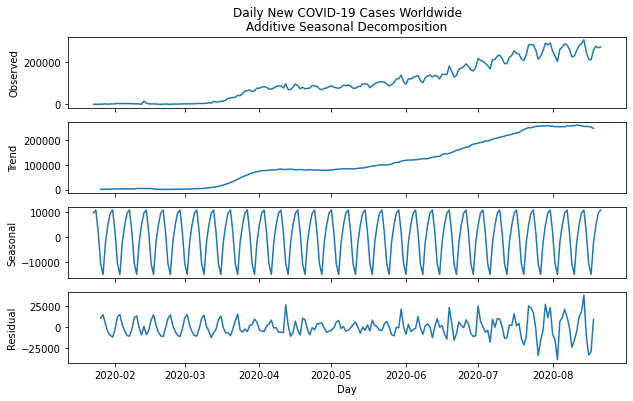

In [57]:
# Let's plot and see the seasonal decomposition

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(seasonal.observed)
axes[0].set_ylabel("Observed")

axes[1].plot(seasonal.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(seasonal.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(seasonal.resid)
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Day")
fig.suptitle("Daily New COVID-19 Cases Worldwide", x=0.513, y=0.95)

del fig, axes

# Fit a Trend Curve
The plot above suggests that there is a non-linear trend hidden in the time series. One approach to discover such a trend is to fit a regression model to the time series and ask the regression model to make predictions at each timestamp. When connected, these chronological predictions form a "trend curve".

In [17]:
def fit_trend(ser, n):
    """
    Takes a series and fits an n-th order polynomial to the series. 
    Returns the predictions. 
    """

    X = np.linspace(1,len(ser),len(ser))
    train_X, train_y = X , np.array(ser) # xi's and yi's

    # Fit a polynomial regression model - code given to you
    train_X = PolynomialFeatures(n).fit_transform(train_X.reshape(-1, 1))
    lin_reg = LinearRegression().fit(train_X, train_y.reshape(-1))
    
    # Make predictions to create the trend curve
    trend_curve = lin_reg.predict(train_X)
    
    return trend_curve

In [20]:
trendline = fit_trend(daily_new_cases, 10)

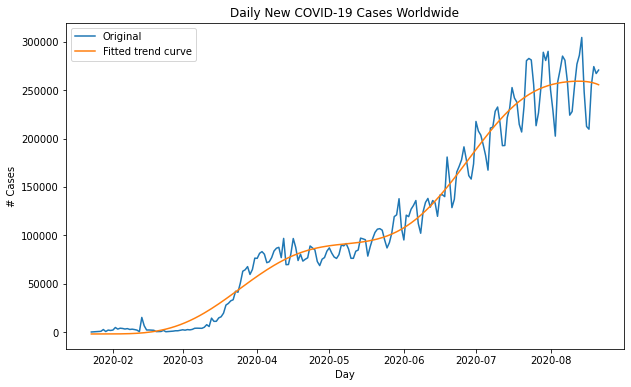

In [23]:
# Let's plot and see your regression line

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(daily_new_cases.index, daily_new_cases.values, label="Original")
ax.plot(daily_new_cases.index, trendline, label="Fitted trend curve")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax

# Calculating Weighted Moving Averages (WMA)

The regression method seems to give a fairly accurate description of the trend hidden in the time series. Next, we will explore an alternative method for discovering trends that is based on moving averages.

In [25]:
def calc_wma(ser, wd_size, weights=1):
    """
    Takes in a series and calculates the WMA with a window size of wd_size
    """
    wma = []
    if isinstance(weights, int):
        weights = np.full(wd_size, weights, dtype=float)

    assert len(weights) == wd_size, "The size of the weights must be the same as the window size. "
    
    for i in range(len(ser)):
        if i < wd_size -1: # starts at 0
            vector = ser[0:i+1] # value window
            
            vector_weighted = np.array([a*b for a,b in zip(vector,weights[(wd_size-i-1):])])
            w = (vector_weighted.sum()) / (weights[(wd_size-i-1):].sum())
            wma.append(w) # add to array
            
        else:
            vector = ser[i - wd_size + 1: i + 1] # value window
            vector_weighted = np.array([a*b for a,b in zip(vector,weights)])
            w = (vector_weighted.sum()) / (weights.sum()) # WMA
            wma.append(w) # add to array
            
    return np.array(wma)

In [26]:
# okay let's get the results
wd_size = 7
weights = np.arange(1, wd_size + 1).astype(float)
wma = calc_wma(daily_new_cases, wd_size, weights)

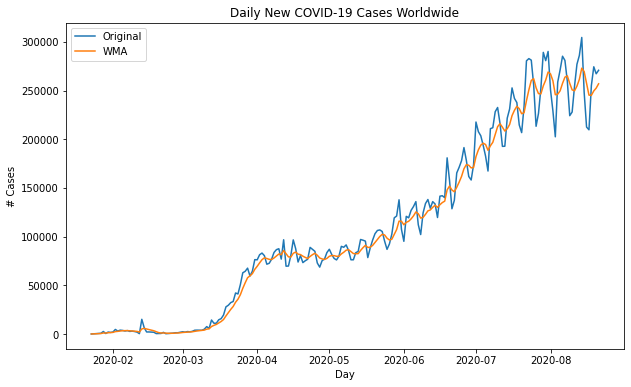

In [27]:
# Let's plot and see your WMA

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(daily_new_cases.index, daily_new_cases.values, label="Original")
ax.plot(daily_new_cases.index, wma, label="WMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax

# Calculate "Time" Exponential Moving Average (EMA)

WMA usually works well if each data point is sampled at regular time intervals (which is the case for our time series). "Time" Exponential Moving Average (EMA), on the other hand, works well on both regular and irregular time series. Let's now explore how to apply EMA to our time series.

In [28]:
def calc_time_ema(ser, lmbd=0.0):
    """
    Takes in a series and calculates EMA with the lambda provided
    """
       
    
    if lmbd == 0:
         time_ema = ser.expanding().mean()
    
    else:
        x = ser
        time_ema = [x[0]] # initialize
        for j in range(1, len(x)):
        
            sumnum = 0
            sumdem = 0
            
            for i in range(j+1):
                
                sumnum += np.exp((x.index[j-1]-x.index[i]).days * -lmbd) * x[i] 
                sumdem += np.exp((x.index[j-1]-x.index[i]).days * -lmbd)
            
            time_ema.append(sumnum/sumdem)
    
    return np.array(time_ema)

In [30]:
ema = calc_time_ema(daily_new_cases, lmbd=0.5)

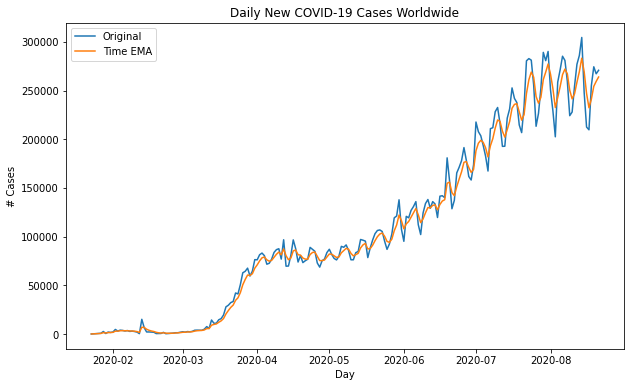

In [31]:
# Let's plot and see your time EMA

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(daily_new_cases.index, daily_new_cases.to_numpy(), label="Original")
ax.plot(daily_new_cases.index, ema, label="Time EMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax

# There is actually an easier way to do this calculation

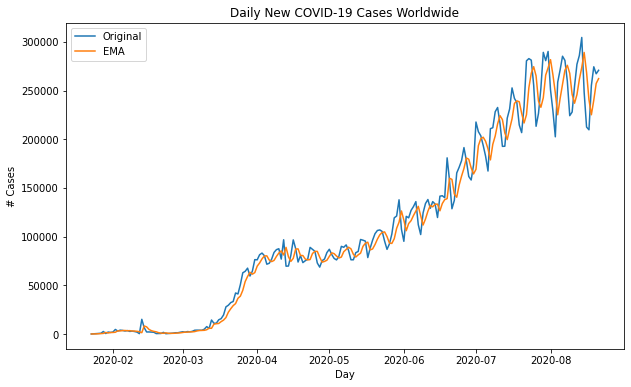

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

ema_2 = SimpleExpSmoothing(daily_new_cases, initialization_method=None).fit(smoothing_level=0.5, optimized=False)

ax.plot(daily_new_cases, label="Original")
ax.plot(ema_2.fittedvalues, label="EMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax

# Next, Time Series Similarities

In [33]:
def load_data():
    covid = pd.read_csv('assets/time_series_covid19_confirmed_global.csv').drop(['Province/State', 'Lat', 'Long'], axis=1)
    covid = covid.set_index('Country/Region')
    
    # get top 5 countires with cumulative cases on 8.21
    top_5 = covid.loc[:,'8/21/20'].sort_values(ascending=False)[:5].index
    daily_new_cases = covid.T[top_5]
    
    # get daily new cases for each country 
    daily_new_cases = daily_new_cases.diff().dropna()
    
    # set index to datetime
    daily_new_cases.index = pd.to_datetime(daily_new_cases.index)
    
    return daily_new_cases

In [34]:
cases = load_data()

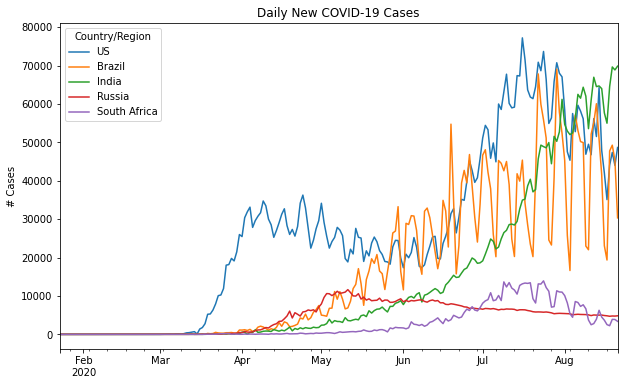

In [35]:
# Let's plot and see the time series
axes = load_data().plot(figsize=(10, 6), title="Daily New COVID-19 Cases", ylabel="# Cases")

del axes

## Extract Seasonal Components

In [70]:
def sea_decomp(df, model="additive"):
    """
    Takes in a DataFrame and extracts the seasonal components
    """
    df = load_data()
    for col in df:
        df[col] = seasonal_decompose(df[col], model=model).seasonal
    sea_df = df
    
    return sea_df

In [60]:
sea_df = sea_decomp(load_data(), "additive")

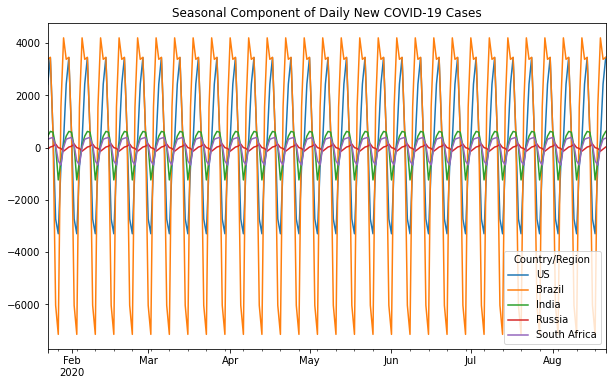

In [61]:
axes = sea_df.plot(figsize=(10, 6), title="Seasonal Component of Daily New COVID-19 Cases")
del axes

# Euclidian Distance
Now, we may start to ask questions like, "which country in the top 5 countries are the most similar to Country A in terms of seasonal patterns?". In addition to the seasonal components that reflect seasonal patterns, we also need a measure of similarity between two time series in order to answer questions like this. One of such measures is the good old Euclidean Distance.

In [62]:
# computes all pairwise Euclidean Distance
i = sea_df.values.T
j = np.nansum((i - i[:, None]) ** 2, axis=2) ** .5
euclidean_dist_df = (lambda v, c: pd.DataFrame(v, c, c))(j, sea_df.columns)

In [63]:
euclidean_dist_df

Country/Region,US,Brazil,India,Russia,South Africa
Country/Region,,,,,
US,0.000000,37616.752035,27032.887714,33986.305519,30084.544171
Brazil,37616.752035,0.000000,57583.437987,63663.896821,60839.376478
India,27032.887714,57583.437987,0.000000,9102.412727,4490.020448
Russia,33986.305519,63663.896821,9102.412727,0.000000,5658.222387
South Africa,30084.544171,60839.376478,4490.020448,5658.222387,0.000000


In [42]:
# compute pairwise Cosine Similarity matrix
cos_sim_df = pd.DataFrame(cosine_similarity(sea_df.T))
ren = {k:v for k,v in zip(range(0,sea_df.shape[1]), sea_df.columns)}

cos_sim_df.rename(ren, axis='index', inplace=True)
cos_sim_df.rename(ren, axis=1, inplace=True)

In [43]:
cos_sim_df

,US,Brazil,India,Russia,South Africa
US,1.000000,0.868859,0.783851,-0.325065,0.664261
Brazil,0.868859,1.000000,0.632741,-0.629987,0.403198
India,0.783851,0.632741,1.000000,0.092292,0.917529
Russia,-0.325065,-0.629987,0.092292,1.000000,0.174437
South Africa,0.664261,0.403198,0.917529,0.174437,1.000000


## Calculate Dynamic Time Warping (DTW) Cost
Last but not least, the cost of aligning two time series can also be used as a similarity measure. Two time series are more similar if it incurs less cost to align them. One of the commonly used alignment costs is the Dynamic Time Warping (DTW) cost, which we will explore now.

In [45]:
def calc_pairwise_dtw_cost(x, y, ret_matrix=False):
    """
    Takes in two series. If ret_matrix=True, returns the full DTW cost matrix; 
    otherwise, returns only the overall DTW cost
    """

    n, m = len(x), len(y)
    
    cost_matrix = np.zeros((m +1, n +1))
    
    dist_fn = lambda a, b: (a - b) ** 2  # Optional helper function 
    
    # Euclidean distance matrix
    dist = np.zeros((m+1, n+1))
    for i in range(m):
        for j in range(n):
            dist[i, j] = (x[j]-y[i])**2
            
    # Initialize
    cost_matrix[0, 0] = dist[0,0]
    for i in range(1,len(y)):
        cost_matrix[i, 0] = dist[i, 0] + cost_matrix[i-1, 0]  
        
    for j in range(1, len(x)):
        cost_matrix[0, j] = dist[0, j] + cost_matrix[0, j-1]

    # Levenshtein distance
    for x_i in range(1, m):
        for y_j in range(1, n):
            cost = dist[x_i, y_j]
            cost_matrix[x_i, y_j] = cost + min([
                    cost_matrix[x_i-1, y_j], 
                     cost_matrix[x_i, y_j-1], 
                     cost_matrix[x_i-1, y_j-1]
                ])

    cost_matrix = cost_matrix[0:212 , 0:212]
    dtw_cost = cost_matrix[n-1,m-1]
    
    return cost_matrix if ret_matrix else dtw_cost

In [47]:
calc_pairwise_dtw_cost(load_data().iloc[:, 0],load_data().iloc[:, 1], ret_matrix=False)

9575974038.0

In [68]:
def calc_dtw_cost(df):
    """
    Takes in a DataFrame and computes all pairwise DTW costs
    """
    matrix = [[calc_pairwise_dtw_cost(df[row], df[col]) for col in df.columns]
          for row in df.columns]
    dtw_cost_df = pd.DataFrame(matrix, df.columns, df.columns)
    
    return dtw_cost_df

Now let's calculate the pairwise DTW costs between seasonal patterns. **We will take the sqaure root so that we can compare it with the Euclidean Distance**.

In [75]:
# Let's show the pairwise DTW costs matrix
np.sqrt(calc_dtw_cost(sea_df))

Country/Region,US,Brazil,India,Russia,South Africa
Country/Region,,,,,
US,0.000000,31878.178988,23565.948799,32327.414867,28016.515162
Brazil,31878.178988,0.000000,53400.789074,61868.013722,57143.198022
India,23565.948799,53400.789074,0.000000,7687.627537,4463.425362
Russia,32327.414867,61868.013722,7687.627537,0.000000,4259.096369
South Africa,28016.515162,57143.198022,4463.425362,4259.096369,0.000000


## Stationarity Tests

Let's first try to understand whether our time series is stationary or not. Recall that a stationary time series has stable statistics, such as constant means and variances, over time. A non-stationary time series would not be very interesting to study, as it is essentially equivalent to a white noise, carrying little information. 

One way of determining stationarity is to calculate some summary statistics. A rolling mean and a rolling standard deviation are the mean and the standard deviation over a rolling window of values. They both have the same length as the original time series.

In [77]:
def calc_rolling_stats(ser, wd_size=7):
    """
    Takes in a series and returns the rolling mean and the rolling std for a window of size wd_size
    """
    
    rolling_mean = list(ser.rolling(wd_size, min_periods=1).mean())
    rolling_std = list(ser.rolling(wd_size, min_periods=1).std(ddof=0))
    
    if wd_size == 1: # replace NaN 
        rolling_std = [ 0 for std in rolling_std]
    
    return np.array(rolling_mean), np.array(rolling_std)

In [85]:
ser, wd_size = daily_new_cases, 7
rolling_mean, rolling_std = calc_rolling_stats(ser, wd_size)

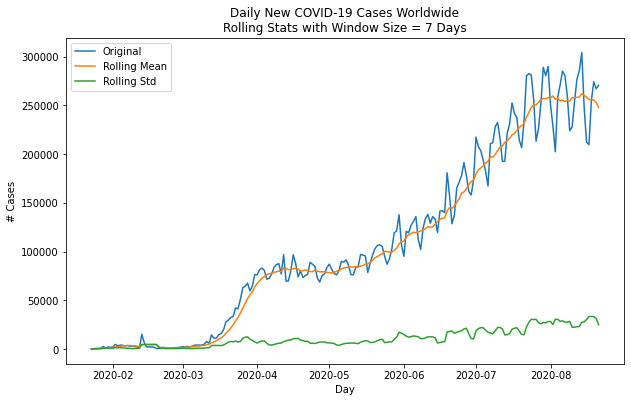

In [86]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(pd.Series(rolling_mean, index=ser.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=ser.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"Rolling Stats with Window Size = {wd_size} Days")
ax.legend()

del fig, ax

### Now let's see whether the *log return* of our time series is stationary.

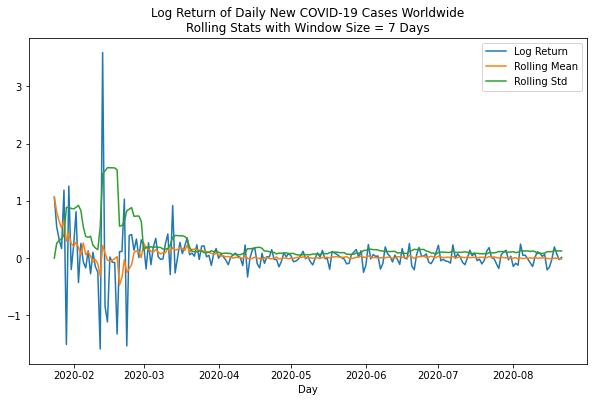

In [89]:
# Let's plot and see the rolling statistics
# skip the first value bc nothing to return
log_ret, wd_size = np.log(ser).diff()[1:], 7
rolling_mean, rolling_std = calc_rolling_stats(log_ret, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(log_ret, label="Log Return")
ax.plot(pd.Series(rolling_mean, index=log_ret.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=log_ret.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_title("Log Return of Daily New COVID-19 Cases Worldwide\n" + f"Rolling Stats with Window Size = {wd_size} Days")
ax.legend()

del fig, ax

Yet another way of determining stationarity would be to use a statistical test, such as the [Augmented Dickey-Fuller unit root test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). The null hypothesis is usually that the time series is non-stationary. A $p$-value less than $0.05$ would lead to the conclusion that the time series is stationary, although some [scientists have rised up against this magic numer](https://www.nature.com/articles/d41586-019-00857-9)!

In [91]:
# An example of performing an Augmented Dickey-Fuller unit root test

from statsmodels.tsa.stattools import adfuller

_, pval, *_ = adfuller(daily_new_cases)
print(f"p-value: {pval}")

del adfuller, pval

p-value: 0.6765852511544095


In [97]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [103]:
# Takes a series and calculates the ACF
acf = sm.tsa.acf(daily_new_cases, nlags=30)

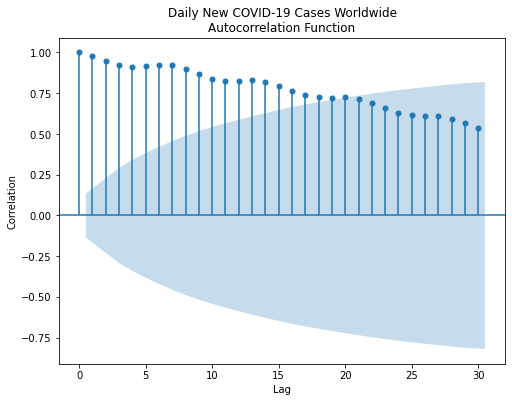

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_acf(daily_new_cases, ax, lags=30, title="Daily New COVID-19 Cases Worldwide\nAutocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax

In [ ]:
# Partial Autocorrelation (PACF)
pacf = sm.tsa.pacf(daily_new_cases, nlags=30)

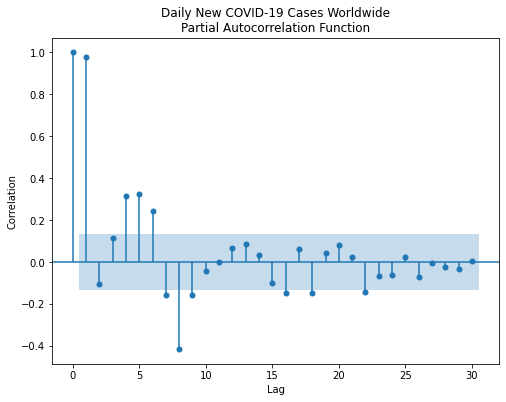

In [105]:
# Let's plot the PACF

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(daily_new_cases, ax, lags=30, title="Daily New COVID-19 Cases Worldwide\nPartial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax

## ARMA on Log Returns

In [106]:
def arma_log_ret(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on log return. 
    Returns a number of forecasts as specified by num_forecasts. 
    """
    mod = ARIMA(np.log(ser),order=(p,1,q))
    model_fit = mod.fit()
    forecasts = np.exp(model_fit.forecast(num_forecasts))
    
    
    return forecasts

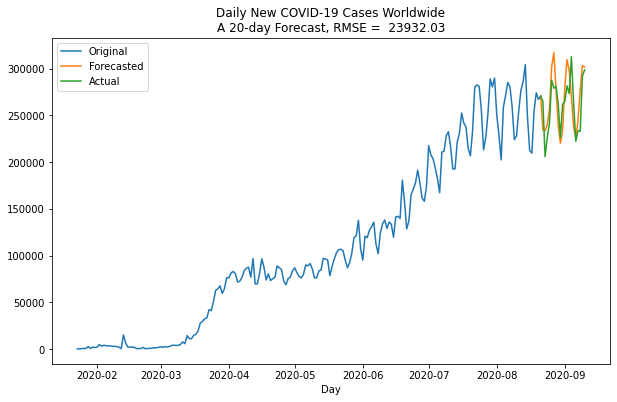

In [120]:
p, q, num_forecasts = 7, 7, 20

forecasts = arma_log_ret(daily_new_cases, p, q, num_forecasts)
actual = pd.read_pickle("assets/actual.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_new_cases, label="Original")
ax.plot(daily_new_cases[-1:].append(forecasts), label="Forecasted")
ax.plot(daily_new_cases[-1:].append(actual), label="Actual")

ax.set_xlabel("Day")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"A {len(forecasts)}-day Forecast, RMSE = {rmse: .2f}")
ax.legend()

del fig, ax

## That looks pretty decent for a prediction

# Vector Autoregression (VAR)

There may be interesting relationships that exist among multiple time series. One way of uncovering such relationships is to perform a VAR, where we model a time series not only with its own observations but also observations from other possibly related time series. Let's explore how to apply VAR to the five time series about daily new COVID-19 cases.

In [114]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults, VARResultsWrapper

def var_first_diff(df, p, num_forecasts):
    """
    Fits a VAR(p) model on the first-order diff on a df and makes num_forecasts forecasts
    """
    data = df.diff().replace([np.inf, -np.inf], np.nan).dropna() # replace infinity
    model = VAR(data)
    var_res = model.fit(p)
    forecast_out = var_res.forecast(data.values[-p:],steps=num_forecasts)
    
    # create DF
    out = pd.DataFrame(forecast_out, 
                             columns = data.columns, 
                             index = pd.date_range("2020-08-22", periods=num_forecasts, freq="D"))
    # need to transform back into non-diff space
    # concat last row orig df, then cum sum, then slice out first row
    forecasts = pd.concat([df[-1:], out], axis=0).cumsum()[1:]
    
    return var_res, forecasts

In [118]:
var_first_diff(cases, p=7, num_forecasts=20)

(<statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x7f8081d82130>,
 Country/Region           US       Brazil        India      Russia  \
 2020-08-22       578.564626   586.665963   594.066127   55.034811   
 2020-08-23     -2728.454422 -6031.950950    46.655454  137.908703   
 2020-08-24     -3293.854422 -7144.674760 -1234.673118    1.842036   
 2020-08-25      -719.521088  1549.577621  -544.749308  -28.929392   
 2020-08-26       284.707483  4202.114239    76.125240 -134.659770   
 2020-08-27      2431.761670  3380.626554   441.179428  -54.886371   
 2020-08-28      3446.796153  3457.641332   621.396176   23.689984   
 2020-08-29       578.564626   586.665963   594.066127   55.034811   
 2020-08-30     -2728.454422 -6031.950950    46.655454  137.908703   
 2020-08-31     -3293.854422 -7144.674760 -1234.673118    1.842036   
 2020-09-01      -719.521088  1549.577621  -544.749308  -28.929392   
 2020-09-02       284.707483  4202.114239    76.125240 -134.659770   
 2020-09-03   

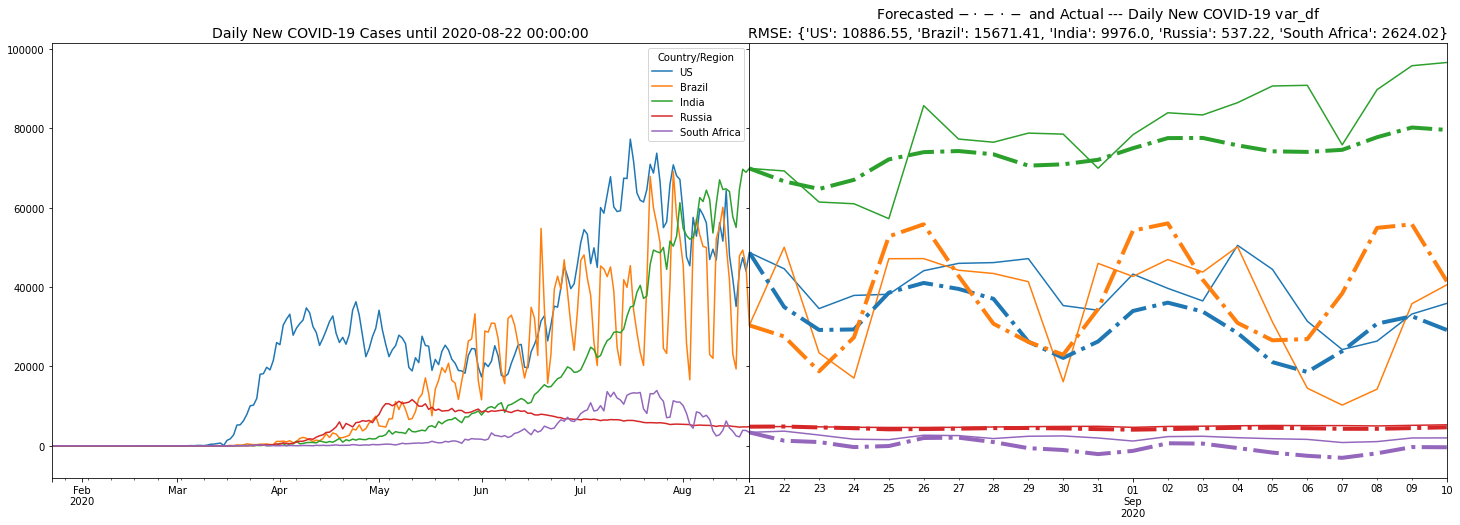

In [122]:
# Let's plot and see the forecasts
p, num_forecasts = 7, 20

var_df = load_data()
_, forecasts = var_first_diff(var_df, p, num_forecasts)

# Here is the actual data for comparison
actual = pd.read_pickle("assets/actual_multi.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2, axis=0)).round(2)

fig, axes = plt.subplots(1, 2, figsize=(25, 8), sharey=True, gridspec_kw={"wspace": 0})

var_df.plot(ax=axes[0])

var_df.iloc[-1:].append(actual).plot(ax=axes[1], legend=False)
axes[1].set_prop_cycle(None)

var_df.iloc[-1:].append(forecasts).plot(ax=axes[1], legend=False, style=["-."] * var_df.shape[-1], linewidth=4)

axes[0].set_title(f"Daily New COVID-19 Cases until {forecasts.index[0]}", fontsize=14)
axes[1].set_title(r"Forecasted $-\cdot-\cdot-$ and Actual --- Daily New COVID-19 var_df" + "\n" + f"RMSE: {rmse.to_dict()}", fontsize=14)

del fig, axes, p, num_forecasts, forecasts, actual, rmse

## Now, let's compare the forecasts made by the $\mathrm{VAR(p)}$ model you trained above with that made by five independent $\mathrm{AR(p)}$ models for each time series. This way, we will be able to see the effect of including observations from possibly related time series on modelling each invidual time series more clearly. 

In [129]:
def arma_first_diff(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on first-order diff. 
    Returns a number of forecasts as specified by num_forecasts. 
    """
    
    mod = ARIMA(ser,order=(p,1,q))
    model_fit = mod.fit()
    forecasts = model_fit.forecast(num_forecasts)
    
    return forecasts

In [130]:
def ar_first_diff(df, p, num_forecasts):
    """
    Fits an AR(p) model on the first-order diff on each time series in df and makes num_forecasts forecasts
    """
    data_list = [list(arma_first_diff(df[ser], p, 0, num_forecasts)) for ser in df.columns]
    data_dict = {k:v for (k,v) in zip(df.columns,data_list)}
    
    # create DF
    forecasts = pd.DataFrame(data_dict,index = pd.date_range("2020-08-22", periods=num_forecasts, freq="D"))
    
    return forecasts

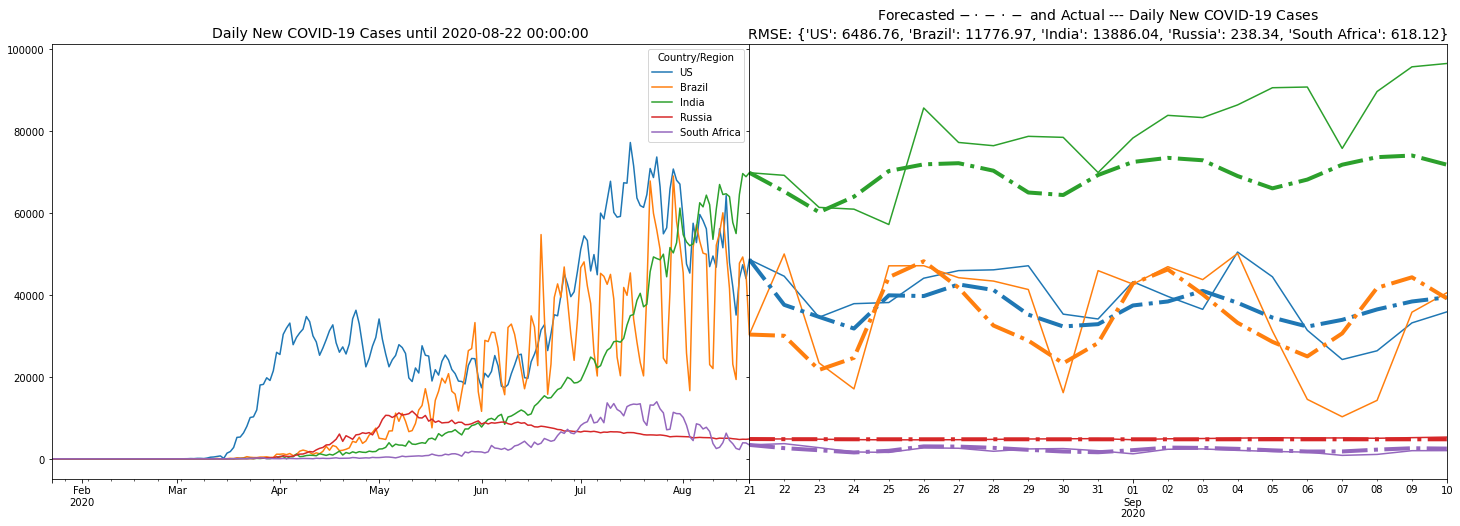

In [131]:
p, num_forecasts = 7, 20

compare_df = load_data()
forecasts = ar_first_diff(compare_df, p, num_forecasts)
actual = pd.read_pickle("assets/actual_multi.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2, axis=0)).round(2)

fig, axes = plt.subplots(1, 2, figsize=(25, 8), sharey=True, gridspec_kw={"wspace": 0})

compare_df.plot(ax=axes[0])

compare_df.iloc[-1:].append(actual).plot(ax=axes[1], legend=False)
axes[1].set_prop_cycle(None)

compare_df.iloc[-1:].append(forecasts).plot(ax=axes[1], legend=False, style=["-."] * compare_df.shape[-1], linewidth=4)

axes[0].set_title(f"Daily New COVID-19 Cases until {forecasts.index[0]}", fontsize=14)
axes[1].set_title(r"Forecasted $-\cdot-\cdot-$ and Actual --- Daily New COVID-19 Cases" + "\n" + f"RMSE: {rmse.to_dict()}", fontsize=14)

del fig, axes, compare_df, p, num_forecasts, forecasts, actual, rmse

# Granger Causality

By comparing the forecasts made by a single $\mathrm{VAR}(p)$ model and by five independent $\mathrm{AR}(p)$ models above, you may notice that the RMSE of one country has improved after we "upgrade" an $\mathrm{AR}(p)$ model to include observations from all other time series. It alerts us about the possible *causality* that may exist among these time series, because the inclusion of some other time series enables us to make better forecasts on another one. 

This is exactly the principle behind Granger Causality test, a statistical test for causality that works by determining whether the inclusion of one time series significantly improves the prediction of the other. Let's now perform a Granger Causality test on each pair of countries and see what we can conclude. 

In [132]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults, VARResultsWrapper

In [133]:
def test_granger(df, p):
    """
    Fits a VAR(p) model on the input df and performs pairwise Granger Causality tests
    """
    # VAR(p)
    data = df.diff().replace([np.inf, -np.inf], np.nan).dropna() # replace infinity
    model = VAR(data)
    var_res = model.fit(p)
    
    # create a pairwise matrix
    matrix = [[var_res.test_causality(i,j).pvalue for j in data.columns] for i in data.columns]
    
    # convert to df
    granger_df = pd.DataFrame(matrix, columns=list(df.columns), index=list(df.columns))
    
    # replace self correlation with NaN
    for i,c in zip(granger_df.index,granger_df.columns):
        if i == c:
            granger_df.at[i,c] = np.nan
        else:
            continue
    
    
    return granger_df

If we believe in the magic threshold of $0.01$ (or $0.05$) for rejecting null hypotheses, we will obtain the following "causality matrix". 

In [134]:
gr = test_granger(load_data(), 7)
caul_mtrx = gr.rename(index={item: f"{item} caused by" for item in gr.index})
caul_mtrx.where(caul_mtrx.isna(), caul_mtrx <= 0.01)

,US,Brazil,India,Russia,South Africa
US caused by,NaN,True,False,False,False
Brazil caused by,False,NaN,True,False,True
India caused by,False,True,NaN,False,True
Russia caused by,True,False,False,NaN,False
South Africa caused by,False,False,False,False,NaN


What do you think about the causality matrix above? <br>
Are there any surprising conclusions? <br>
Do you believe in the Granger Causality test we just performed?